In [43]:
import torch
from torch import nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 3               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 64
TIME_STEP = 28          # rnn time step / image height
INPUT_SIZE = 28         # rnn input size / image width
LR = 0.01               # learning rate
DOWNLOAD_MNIST = True   # set to True if haven't download the data

train_data = dsets.MNIST(
    root='./mnist/',
    train=True,                         # this is training data
    transform=transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                        # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,            # download it if you don't have it
)

torch.Size([60000, 28, 28])
torch.Size([60000])


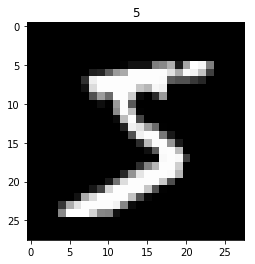

In [44]:
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()


In [45]:
# Data Loader for easy mini-batch return in training
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# convert test data into Variable, pick 2000 samples to speed up testing
test_data = dsets.MNIST(root='./mnist/', train=False, transform=transforms.ToTensor())
test_x = test_data.test_data.type(torch.FloatTensor)/255.   # shape (2000, 28, 28) value in range(0,1)
test_y = test_data.test_labels.numpy().squeeze()   # covert to numpy array

In [46]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=64,         # rnn hidden unit
            num_layers=2,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
            bidirectional=True,
            dropout=0.25
        )

        self.out = nn.Linear(64*2, 10)
        for name, param in self.rnn.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_normal_(param)
        for name, param in self.out.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_normal_(param)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out


rnn = RNN()
print(rnn)

RNN(
  (rnn): LSTM(28, 64, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (out): Linear(in_features=128, out_features=10, bias=True)
)


In [47]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# training and testing
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):        # gives batch data
        b_x = b_x.view(-1, 28, 28)              # reshape x to (batch, time_step, input_size)

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = float(sum(pred_y == test_y)) / float(test_y.size)
            print('Epoch: %d' % epoch + '| train loss: %.4f' % loss.data.numpy() + '| test accuracy: %.2f' % accuracy)

Epoch: 0| train loss: 2.3054| test accuracy: 0.10
Epoch: 0| train loss: 1.1164| test accuracy: 0.61
Epoch: 0| train loss: 0.6358| test accuracy: 0.77
Epoch: 0| train loss: 0.1944| test accuracy: 0.88
Epoch: 0| train loss: 0.4495| test accuracy: 0.88
Epoch: 0| train loss: 0.2164| test accuracy: 0.91
Epoch: 0| train loss: 0.1883| test accuracy: 0.92
Epoch: 0| train loss: 0.0682| test accuracy: 0.93
Epoch: 0| train loss: 0.1880| test accuracy: 0.94
Epoch: 0| train loss: 0.2065| test accuracy: 0.94
Epoch: 0| train loss: 0.2280| test accuracy: 0.94
Epoch: 0| train loss: 0.2187| test accuracy: 0.95
Epoch: 0| train loss: 0.1469| test accuracy: 0.95
Epoch: 0| train loss: 0.2506| test accuracy: 0.96
Epoch: 0| train loss: 0.0818| test accuracy: 0.96
Epoch: 0| train loss: 0.2333| test accuracy: 0.96
Epoch: 0| train loss: 0.1479| test accuracy: 0.96
Epoch: 0| train loss: 0.2440| test accuracy: 0.96
Epoch: 0| train loss: 0.1546| test accuracy: 0.96
Epoch: 1| train loss: 0.0908| test accuracy: 0.97


In [48]:
test_output = rnn(test_x.view(-1, 28, 28))
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(float(sum(pred_y == test_y)) / float(test_y.size))

0.9764


In [49]:
pred_y[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [50]:
test_y[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])